<a href="https://colab.research.google.com/github/NevanioNazario/EASI651/blob/main/PROJET_MECANIQUE_NUMERIQUE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


bilan des efforts
    bilan des forces en x =  -7.806912449837e-09  N
    bilan des forces en y =  -3.660716174636036e-11  N
    bilan des forces en z =  -7.865310180932283e-09  N


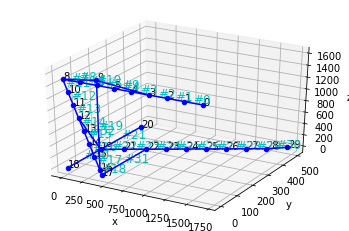

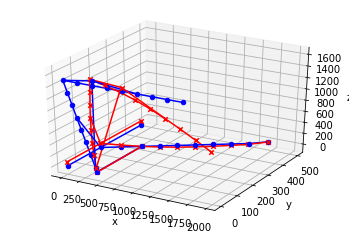

In [1]:
# -*- coding: utf-8 -*-
"""
CrESted on Thu Apr 26 22:32:02 2019

@author: Philippe Saffré

Ce programme effectue la resolution d'un modele EF en elements de type barre
et/ou poutre en statique 3D.
Une astuce pour mixer elements barre et poutre est de definir les dimensions 
de toutes les matrices de raideur elementaires comme pour des elements poutre,
et donc considerer 6 ddl par noeuds en 3D, même pour des elements barre.

Les donnees d'entree sont fournies par un fichier excel "structure_3D.xlsx" 
qui doit presenter les noeuds, les elements et leur proprietes, 
les conditions aux limites et le chargement.

Au cours de son execution, ce programme calcule les matrices de raideur
elementaires, les assemble pour constituer la matrice de raideur structure, 
qui est son tour modifiee en fonction des CL pour ecrire la matrice de raideur
reduite.
La resolution du systeme [F]=[Kstruct].[U] permet de determiner le vecteur des
deplacements nodaux, puis les inconnues de liaison et le vecteur des efforts 
nodaux.
En post-traitement les vecteurs deformations et contraintes, ainsi que 
les contraintes axiales issues des efforts normaux sont calculees pour 
chaque element.

Les traces du modele deforme et des contraintes axiales sont aussi realises.

"""

# Packages
import numpy as np                # Numpy
import matplotlib.pyplot as plt   # Pyplot
import pandas as pd               # Pandas
from mpl_toolkits.mplot3d.axes3d import Axes3D
from scipy.linalg import block_diag

"""
   ----------------------------------------------------
 	LECTURE DES DONNEES DE MODELISATION
   ----------------------------------------------------
"""

with pd.ExcelFile('structure_3D.xlsx') as xls :
    coord=np.float64(np.array(pd.read_excel(xls, 'noeuds')))
    coord=np.delete(coord,0,1)
    El=np.array(pd.read_excel(xls, sheet_name='elements'))
    El=np.delete(El,0,1)
#    prop=pd.read_excel(xls, 'proprietes',names=["E","nu","Ri","Re","type"])
    prop=pd.read_excel(xls,'proprietes',header=0)#,names=["E","nu","Ri","Re","type"])
    del prop['Unnamed: 0']
    CL=pd.read_excel(xls, 'CL')
    charges=pd.read_excel(xls,'charges')

Kstruct=np.zeros((6*len(coord),6*len(coord)))
Epsix=np.zeros(len(El))
Sigx=np.zeros(len(El))

"""
   -----------------------------------------------------------
   Fonction calcul des produits ES et EI
   -----------------------------------------------------------
"""

def ES (i):
    return prop['E'][i]*np.pi*((prop['Re'][i])**2-(prop['Ri'][i])**2)

def EI (i):
    return prop['E'][i]*np.pi*((prop['Re'][i])**4-(prop['Ri'][i])**4)/4

def GI (i):
    return (prop['E'][i]/2/(1+prop['nu'][i]))*np.pi*((prop['Re'][i])**4-(prop['Ri'][i])**4)/2

"""
   -----------------------------------------------------------
   Fonction calcul de longueur d un element, Cx, Cy et Cz (voir p121 du cours)
   -----------------------------------------------------------
"""

def L (i) :
    return np.sqrt((coord[El[i,1],0]-coord[El[i,0],0])**2+(coord[El[i,1],1]-coord[El[i,0],1])**2+(coord[El[i,1],2]-coord[El[i,0],2])**2)

def Cx (i) :
    return (coord[El[i,1],0]-coord[El[i,0],0])/L(i)

def Cy (i) :
    return (coord[El[i,1],1]-coord[El[i,0],1])/L(i)
    
def Cz (i) :
    return (coord[El[i,1],2]-coord[El[i,0],2])/L(i)
    
"""
   -----------------------------------------------------------
   Fonction matrice de rigidite elementaire
   -----------------------------------------------------------
"""

def matrice_P (i) :    # matrice passage
    P=np.zeros((12,12))

    if Cx(i) == 0 and Cz(i) == 0 :
        Tb=np.array([[1,0,0],[0,1,0],[0,0,1]])    # matrice de passage (voir p118 du cours)
    else :
        cosb=Cx(i)/(np.sqrt(Cx(i)**2+Cz(i)**2))
        sinb=Cz(i)/(np.sqrt(Cx(i)**2+Cz(i)**2))
        Tb=np.array([[cosb,0,sinb],[0,1,0],[-sinb,0,cosb]])    # matrice de passage (voir p118 du cours)

    cosg=np.sqrt(Cx(i)**2+Cz(i)**2)
    sing=Cy(i)
    Tg=np.array([[cosg,sing,0],[-sing,cosg,0],[0,0,1]])    # matrice de passage (voir p118 du cours)
    T=np.dot(Tg,Tb)
    P = block_diag(T, T, T, T) #On construit la matrice de passage de la 2D à la 3D
    return P
    
def matrice_Ke (i) :    # matrice élémentaire
    Ke=np.zeros((12,12))
    Ke[0,0]=ES(i)/L(i)
    Ke[0,6]=-ES(i)/L(i)
    Ke[6,0]=-ES(i)/L(i)
    Ke[6,6]=ES(i)/L(i)

    if prop['type'][i] == 'poutre' :       # si élément poutre
        Ke[1,1]=12*EI(i)/(L(i))**3
        Ke[1,5]=6*EI(i)/(L(i))**2
        Ke[1,7]=-12*EI(i)/(L(i))**3
        Ke[1,11]=6*EI(i)/(L(i))**2
        Ke[2,2]=12*EI(i)/(L(i))**3
        Ke[2,4]=-6*EI(i)/(L(i))**2
        Ke[2,8]=-12*EI(i)/(L(i))**3
        Ke[2,10]=-6*EI(i)/(L(i))**2
        Ke[3,3]=GI(i)/(L(i))
        Ke[3,9]=-GI(i)/(L(i))
        Ke[4,2]=-6*EI(i)/(L(i))**2
        Ke[4,4]=4*EI(i)/(L(i))
        Ke[4,8]=6*EI(i)/(L(i))**2
        Ke[4,10]=2*EI(i)/(L(i))
        Ke[5,1]=6*EI(i)/(L(i))**2
        Ke[5,5]=4*EI(i)/(L(i))
        Ke[5,7]=-6*EI(i)/(L(i))**2
        Ke[5,11]=2*EI(i)/(L(i))
        Ke[7,1]=-12*EI(i)/(L(i))**3
        Ke[7,5]=-6*EI(i)/(L(i))**2
        Ke[7,7]=12*EI(i)/(L(i))**3
        Ke[7,11]=-6*EI(i)/(L(i))**2
        Ke[8,2]=-12*EI(i)/(L(i))**3
        Ke[8,4]=6*EI(i)/(L(i))**2
        Ke[8,8]=12*EI(i)/(L(i))**3
        Ke[8,10]=6*EI(i)/(L(i))**2
        Ke[9,3]=-GI(i)/(L(i))
        Ke[9,9]=GI(i)/(L(i))
        Ke[10,2]=-6*EI(i)/(L(i))**2
        Ke[10,4]=2*EI(i)/(L(i))
        Ke[10,8]=6*EI(i)/(L(i))**2
        Ke[10,10]=4*EI(i)/(L(i))
        Ke[11,1]=6*EI(i)/(L(i))**2
        Ke[11,5]=2*EI(i)/(L(i))
        Ke[11,7]=-6*EI(i)/(L(i))**2
        Ke[11,11]=4*EI(i)/(L(i))
    elif prop['type'][i] != 'barre' and prop['type'][i] != 'poutre' :
        print('erreur sur le type d element')
    Ke=np.dot(matrice_P(i).T,Ke)
    Ke=np.dot(Ke,matrice_P(i))    # matrice élémentaire
    return Ke

"""
   -----------------------------------------------------------
   ASSEMBLAGE DE LA MATRICE DE RIGIDITE Kstruct
   -----------------------------------------------------------
"""

for i in range(len(El)):
    elemddl=np.array([El[i,0]*6,El[i,0]*6+1,El[i,0]*6+2,El[i,0]*6+3,El[i,0]*6+4,El[i,0]*6+5,El[i,1]*6,El[i,1]*6+1,El[i,1]*6+2,El[i,1]*6+3,El[i,1]*6+4,El[i,1]*6+5])    # assemblage matrices
    Kstruct[np.ix_(elemddl,elemddl)] +=matrice_Ke(i)

"""
   ----------------------------------------------------
   ECRITURE DU VECTEUR DES EFFORTS IMPOSES AUX NOEUDS
   ----------------------------------------------------
"""

F=np.zeros(6*len(coord))
for i in range(len(charges)):
    F[6*charges['nn'][i]+charges['dir'][i]]=charges['val'][i]

"""
   ----------------------------------------------------
   MODIFICATION des CL en rotation sur elements barre

Vu la modification des matrices de raideur des elements barre, les lignes
et colonnes correspondant aux rotations ne sont pas alimentees et ne
comportent que des termes nuls, ce qui rendra non inversible la matrice Kred.
L'astuce consiste a identifier ces lignes et colonnes et a les modifier comme
s'il s'agissait de ddl bloques.
   ----------------------------------------------------
"""

liste_nn_poutre=[]
for i in range(len(El)):
    if prop['type'][i] == 'poutre' :
        if El[i,0] not in liste_nn_poutre :
            liste_nn_poutre.append(El[i,0])
        if El[i,1] not in liste_nn_poutre :
            liste_nn_poutre.append(El[i,1])
liste_nn_barre=list(range(len(coord)))
for i in liste_nn_poutre :
    liste_nn_barre.remove(i)
for e in liste_nn_barre :
    CL_add = [{'nn': e, 'ddl': 3}]
    CL=CL.append(CL_add, ignore_index=True)
    CL_add = [{'nn': e, 'ddl': 4}]
    CL=CL.append(CL_add, ignore_index=True)
    CL_add = [{'nn': e, 'ddl': 5}]
    CL=CL.append(CL_add, ignore_index=True)
    
"""
   ----------------------------------------------------
   SIMPLIFICATION DE Kstruct en fonction des CL (Ecriture de Kred)
   ----------------------------------------------------
"""

Kred=np.copy(Kstruct)
for i in range(6*len(coord)):
    for j in range(len(CL)):
        Kred[6*CL['nn'][j]+CL['ddl'][j],i]=0
        Kred[i,6*CL['nn'][j]+CL['ddl'][j]]=0
for j in range(len(CL)):
    Kred[6*CL['nn'][j]+CL['ddl'][j],6*CL['nn'][j]+CL['ddl'][j]]=1
    
"""
   ----------------------------------------------------
   MODIFICATION DU VECTEUR DES EFFORTS en fonction des CL

A toute CL imposée, l'effort correspondant est un effort de liaison inconnu,
qui sera déterminé après le calcul des déplacements. En conséquence, même si
le noeud est soumis à un effort extérieur du même type que l'effort de liaison,
celui-ci doit apparaître nul dans le vecteur des efforts.
   ----------------------------------------------------
"""
for i in range(len(CL)):
    F[6*CL['nn'][i]+CL['ddl'][i]]=0
"""

   ----------------------------------------------------
   RESOLUTION DU SYSTEME ET CALCUL DE {U}
   ----------------------------------------------------
"""

U=np.linalg.solve(Kred,F)

"""
   ----------------------------------------------------
   CALCUL DE {F} ET DES EFFORTS DE LIAISON 
   ----------------------------------------------------
"""

F=np.dot(Kstruct,U)

"""
   ----------------------------------------------------
   VERIFICATION EQUILIBRE STATIQUE - BILAN DES EFFORTS
   ----------------------------------------------------
"""

print()
bilan=np.zeros(3)
for i in range(len(coord)):
    bilan[0]=bilan[0]+F[6*i]
    bilan[1]=bilan[1]+F[6*i+1]
    bilan[2]=bilan[2]+F[6*i+2]
print('bilan des efforts')
print('    bilan des forces en x = ',bilan[0],' N')
print('    bilan des forces en y = ',bilan[1],' N')
print('    bilan des forces en z = ',bilan[2],' N')

"""
	-----------------------------------------------------------------
	AFFICHAGE DE LA DEFORMEE ET DU MAILLAGE INITIAL
	-----------------------------------------------------------------
"""

# Calcul de la deformee assortie d une echelle x5

coord3=np.zeros((len(coord),3))
for i in range(len(coord)):
    coord3[i,0]=coord[i,0]+10*U[6*i]
    coord3[i,1]=coord[i,1]+10*U[6*i+1]
    coord3[i,2]=coord[i,2]+10*U[6*i+2]

# Tracés

coord2 = coord.transpose()
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
# Les noeuds
for i in range(len(coord)) :
    ax.scatter(coord2[0,i], coord2[1,i], coord2[2,i], c= "blue", marker="o")
    ax.text(coord2[0,i]+2, coord2[1,i]+2, coord2[2,i]+0,  '%s' % (str(i)), size=10, zorder=1, color='k')
# Les elements
p = np.mean(coord[El],axis=1)
for i in range(len(El)):
    conn=El[i]
    ax.plot(coord2[0,conn[:2]], coord2[1,conn[:2]], coord2[2,conn[:2]], color = "blue")
    ax.text(p[i,0], p[i,1], p[i,2], '#%s' % (str(i)), size=12, zorder=1, color='c') # label elements
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()
   
coord3 = coord3.transpose()
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
# Les noeuds
for i in range(len(coord)) :
    ax.scatter(coord2[0,i], coord2[1,i], coord2[2,i], c= "blue", marker="o")
    ax.scatter(coord3[0,i], coord3[1,i], coord3[2,i], c= "red", marker="x")
# Les elements
for i in range(len(El)):
    conn=El[i]
    ax.plot(coord2[0,conn[:2]], coord2[1,conn[:2]], coord2[2,conn[:2]], color = "blue")
    ax.plot(coord3[0,conn[:2]], coord3[1,conn[:2]], coord3[2,conn[:2]], color = "red")    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()
   
"""
   --------------------------------------------------------
   CALCUL DES DEFORMATIONS ET CONTRAINTES AXIALES
   --------------------------------------------------------
"""
 
for i in range(len(El)):
    elemddl=np.array([El[i,0]*6,El[i,0]*6+1,El[i,0]*6+2,El[i,0]*6+3,El[i,0]*6+4,El[i,0]*6+5,El[i,1]*6,El[i,1]*6+1,El[i,1]*6+2,El[i,1]*6+3,El[i,1]*6+4,El[i,1]*6+5])    # assemblage matrices
    Uelocal=np.dot(matrice_P(i),U[elemddl])    
    Epsix[i] = np.dot(np.array([-1/L(i),1/L(i)]),[Uelocal[0],Uelocal[6]])   # contraintes fibre neutre
    Sigx[i] = prop['E'][i]*Epsix[i]   # contraintes fibre neutre
  
U=np.reshape(U,(len(coord),6))
F=np.reshape(F,(len(coord),6))
